# Loading the dataset

In [231]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from scipy.stats import randint


train_path = 'kaggle_housing_data/train.csv'
test_path = 'kaggle_housing_data/test.csv'

df_test = pd.read_csv(test_path)
df_train = pd.read_csv(train_path)
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Remove majority null or majority single value features

In [232]:
from src import utils
try:
    df_train.drop("Id", axis=1, inplace=True)
    df_test.drop("Id", axis=1, inplace=True)
except:
    print("Id columns already removed.")

utils.drop_null_majority_features(df_train, df_test)
utils.drop_single_val_majority(df_train, df_test)
print(f"after:\n {df_train.describe()}")


after:
         MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1    BsmtUnfSF  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726   567.240411  ...   
std      30.202904     20.645407   181.066207   456.098091   441.86

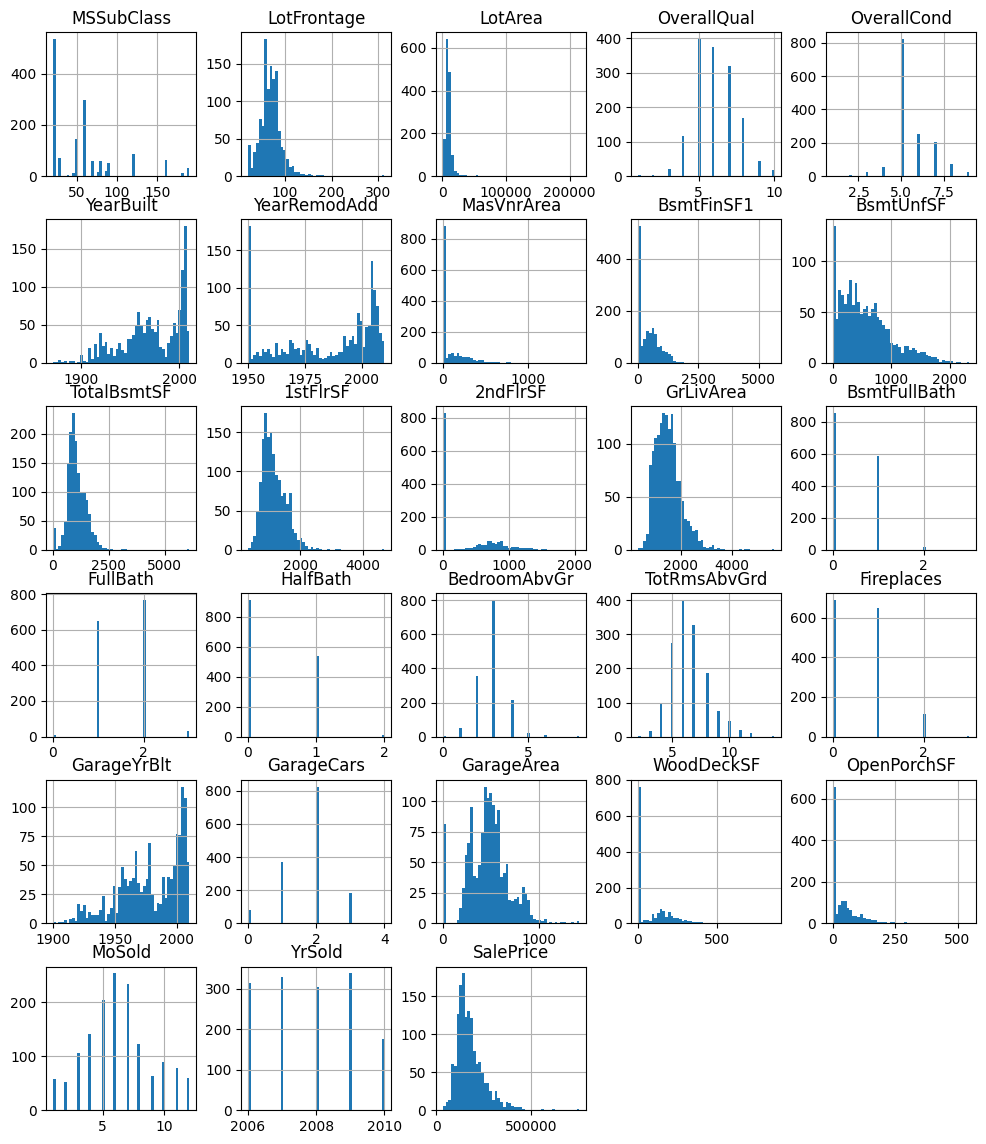

In [233]:

df_train.hist(bins=50, figsize=(12, 14))
plt.show()

In [234]:
corr_matrix = df_train.corr(numeric_only=True)
print(corr_matrix["SalePrice"].sort_values(ascending=False))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
MoSold          0.046432
YrSold         -0.028923
OverallCond    -0.077856
MSSubClass     -0.084284
Name: SalePrice, dtype: float64


# Stratified split of the data based on overall quality of the house

In [235]:
strat_train_set, strat_test_set = train_test_split(
    df_train, test_size=0.2, stratify=df_train["OverallQual"],
    random_state=42
)

KeyboardInterrupt: 

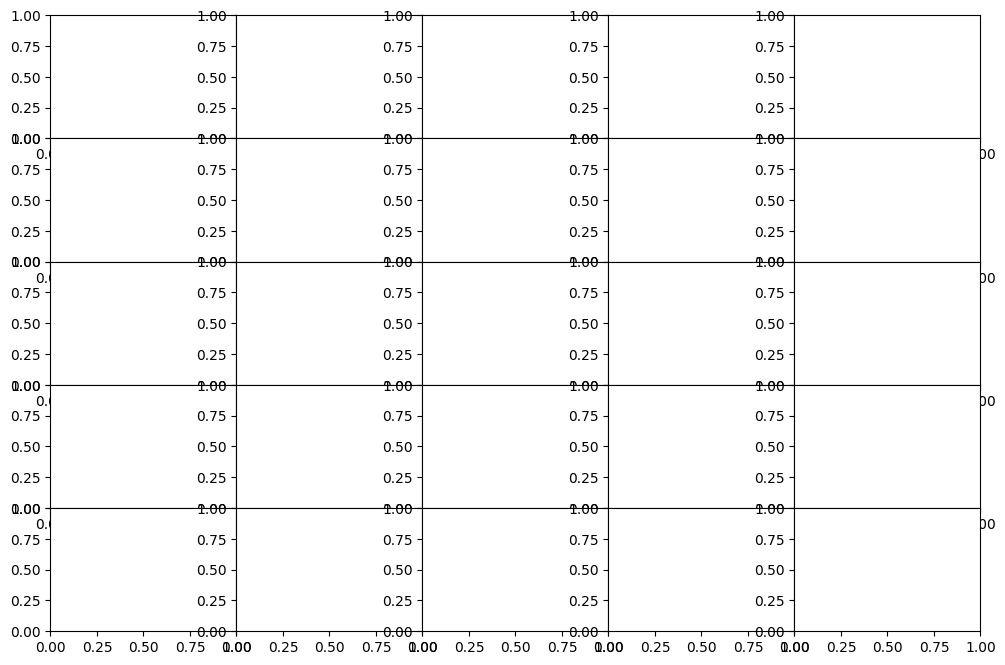

In [236]:

attributes = ["SalePrice", "OverallQual", "GrLivArea", "GarageCars",
              "GarageArea"]

scatter_matrix(strat_train_set[attributes], figsize=(12, 8))
plt.show()

Lets try to make some new useful features

In [ ]:
housing = strat_train_set.copy()

In [ ]:
housing["1stFlrRatio"] = housing["1stFlrSF"] / housing["GrLivArea"]
housing["yrsSinceRemod"] = housing["YrSold"] - housing["YearRemodAdd"]
housing["bdrmRatio"] = housing["BedroomAbvGr"] / housing["TotRmsAbvGrd"]

In [ ]:
corr_matrix = housing.corr(numeric_only=True)
print(corr_matrix["SalePrice"].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.800531
GrLivArea        0.700908
GarageCars       0.651388
GarageArea       0.634647
TotalBsmtSF      0.604969
1stFlrSF         0.596394
FullBath         0.563145
TotRmsAbvGrd     0.534714
YearBuilt        0.528381
YearRemodAdd     0.526142
GarageYrBlt      0.493869
Fireplaces       0.462406
MasVnrArea       0.461716
LotFrontage      0.353105
BsmtFinSF1       0.351111
OpenPorchSF      0.325071
WoodDeckSF       0.312707
2ndFlrSF         0.307961
HalfBath         0.290130
LotArea          0.275339
BsmtUnfSF        0.242704
BsmtFullBath     0.231159
BedroomAbvGr     0.175717
MoSold           0.083639
YrSold          -0.005636
OverallCond     -0.081920
MSSubClass      -0.087740
1stFlrRatio     -0.141768
bdrmRatio       -0.338678
yrsSinceRemod   -0.527126
Name: SalePrice, dtype: float64


Bedroom ratio and Days since remodelling seem like pretty good correlated features, lets plot them on a scatterplot

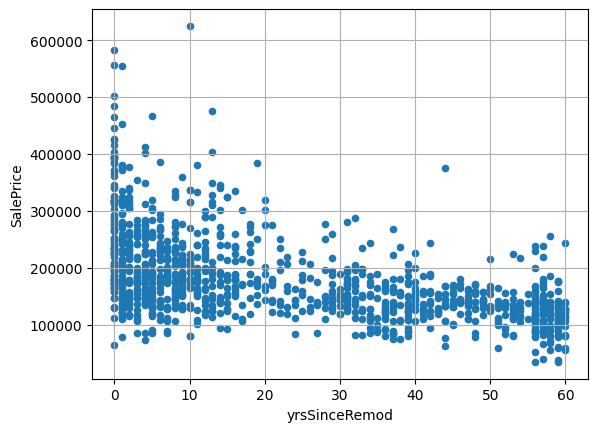

In [ ]:
housing.plot(kind="scatter", x="yrsSinceRemod", y="SalePrice", grid=True)
plt.show()

# Creating the transformer pipeline

Custom transformer for negative skewed/ left tailed data

In [ ]:
class LeftToRightSkewTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=1e-6):
        self.epsilon = epsilon
        self.max_val = None
        
    def fit(self, X, y=None):
        self.max_val = np.max(X)
        return self
    
    def transform(self, X):
        if self.max_val is None:
            raise RuntimeError("LeftToRightSkewTransformer is not fitted. Call fit() first.")
        
        X_np = np.asarray(X)
        return self.max_val - X_np + self.epsilon
    
    def get_feature_names_out(self, names=None):
        return [f"{f}_reflected" for f in names]

In [ ]:

def column_ratio(X):
    return X[:, [0]] + 1e-6 / (X[:, [1]] + 1e-6)

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio,
                            feature_names_out=ratio_name),
        StandardScaler()
    )
    
def column_sub(X):
    return X[:, [0]] - X[:, [1]] + 1e-6

def sub_name(function_transformer, feature_names_in):
    return ["subtraction"]

def sub_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_sub,
                            feature_names_out=sub_name),
        StandardScaler()
    )
    
right_skew_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("log", FunctionTransformer(func=lambda x: np.log(x + 1e-6), 
                                    feature_names_out="one-to-one")),
        ("standard", StandardScaler())
    ]
)

left_skew_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("leftskew", LeftToRightSkewTransformer(epsilon=1e-6)),
        ("log", FunctionTransformer(np.log, feature_names_out="one-to-one")),
        ("standard", StandardScaler())
    ]
)

default_num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("standard", StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

def left_skew(X=None):
    return left_skew_pipeline

target_pipeline = Pipeline(
    steps=[
        ("transform",
        FunctionTransformer(func=left_skew, 
                            inverse_func=np.exp,
                            feature_names_out="one-to-one")),
    ]
)

preprocessing = ColumnTransformer(
    [
        ("floor1_to_house_sf", ratio_pipeline(), ["1stFlrSF", "GrLivArea"]),
        ("last_remodel", sub_pipeline(), ["YrSold", "YearRemodAdd"]),
        ("bedroom_to_rooms", ratio_pipeline(), ["BedroomAbvGr", "TotRmsAbvGrd"]),
        ("right_skew", right_skew_pipeline, ["LotFrontage", "LotArea", "BsmtUnfSF",
                                             "TotalBsmtSF", "1stFlrSF", "GrLivArea"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object))
    ],
    remainder=default_num_pipeline
)

In [ ]:
housing = strat_train_set.drop("SalePrice", axis=1)
housing_labels = strat_train_set["SalePrice"].copy()



housing_prepared = preprocessing.fit_transform(housing)
housing_prepared_dense = housing_prepared.toarray()
# housing_prepared_dense

df_housing_prepared = pd.DataFrame(
    housing_prepared_dense,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index
)
df_housing_prepared



TypeError: loop of ufunc does not support argument 0 of type SimpleImputer which has no callable exp method

Testing scaling to Gaussian distribution on skewed numerical features 